In [8]:
import json
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SpatialDropout1D, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import logging

In [9]:
with open('intents.json') as file:
    data = json.load(file)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [10]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w not in stop_words and w.isalnum()]
    return " ".join(tokens)

In [11]:
words = []
classes = []
documents = []
for intent in data['intents']:
    for pattern in intent['patterns']:
        pattern = preprocess_text(pattern)
        words.extend(pattern.split())
        documents.append((pattern, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = sorted(set(words))
classes = sorted(set(classes))

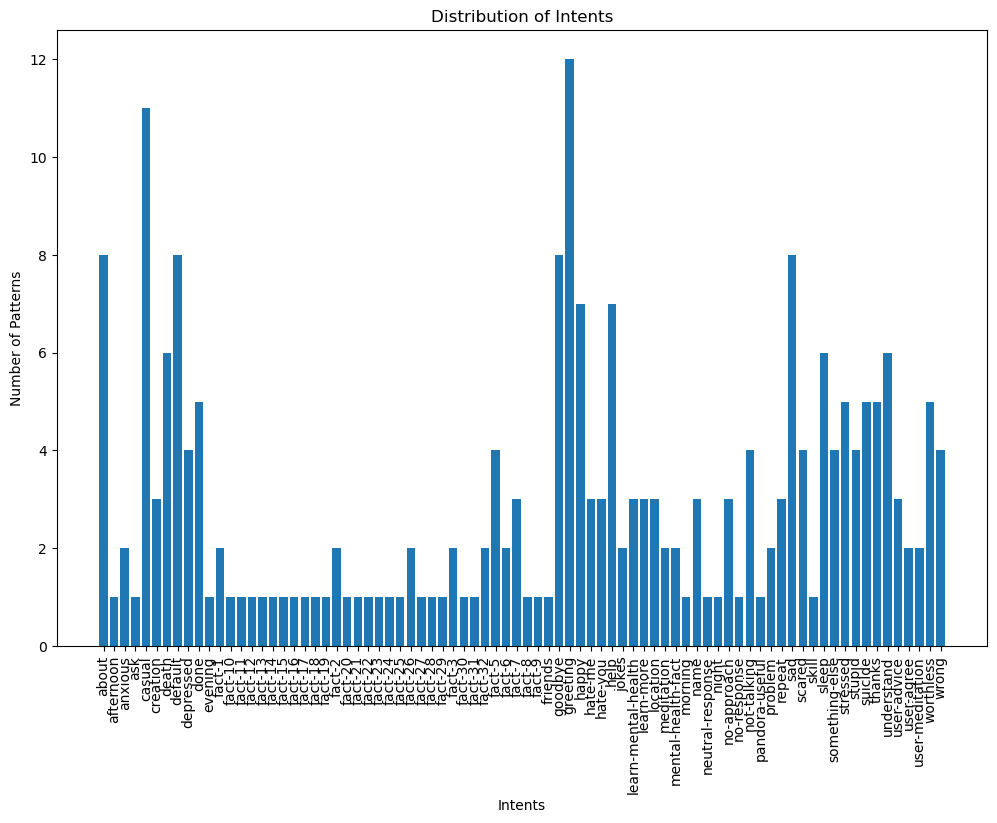

In [12]:
intent_counts = {intent: 0 for intent in classes}
for doc in documents:
    intent_counts[doc[1]] += 1

plt.figure(figsize=(12, 8))
plt.bar(intent_counts.keys(), intent_counts.values())
plt.title('Distribution of Intents')
plt.xlabel('Intents')
plt.ylabel('Number of Patterns')
plt.xticks(rotation=90)
plt.show()

In [13]:
training_sentences = [doc[0] for doc in documents]
training_labels = [classes.index(doc[1]) for doc in documents]
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(training_sentences)
X_train = tokenizer.texts_to_sequences(training_sentences)
X_train = pad_sequences(X_train)

y_train = np.array(training_labels)

In [14]:
class_counts = Counter(y_train)
print("Class distribution before SMOTE:", class_counts)

Class distribution before SMOTE: Counter({44: 12, 4: 11, 43: 8, 0: 8, 65: 8, 7: 8, 48: 7, 45: 7, 68: 6, 6: 6, 74: 6, 73: 5, 70: 5, 78: 5, 9: 5, 72: 5, 8: 4, 61: 4, 66: 4, 79: 4, 71: 4, 69: 4, 37: 4, 5: 3, 56: 3, 47: 3, 46: 3, 64: 3, 52: 3, 59: 3, 51: 3, 75: 3, 50: 3, 39: 3, 2: 2, 49: 2, 63: 2, 76: 2, 53: 2, 77: 2, 54: 2, 11: 2, 22: 2, 33: 2, 38: 2, 29: 2, 36: 2, 55: 1, 1: 1, 10: 1, 58: 1, 60: 1, 57: 1, 67: 1, 42: 1, 3: 1, 62: 1, 40: 1, 41: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 30: 1, 31: 1, 32: 1, 34: 1, 35: 1})


In [15]:
apply_smote = all(count >= 6 for count in class_counts.values())

if apply_smote:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE()
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
else:
    X_train_res, y_train_res = X_train, y_train

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_res, y_train_res, test_size=0.2, random_state=42)

In [17]:
def build_model(model_type='LSTM'):
    model = Sequential()
    model.add(Embedding(input_dim=2000, output_dim=128, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.3))
    if model_type == 'LSTM':
        model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01))))
    elif model_type == 'GRU':
        model.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01))))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(classes), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
def train_and_evaluate(model_type='LSTM'):
    model = build_model(model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=150, batch_size=5, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])
    model.save(f'chatbot_model_{model_type}.keras')
    val_predictions = model.predict(X_val)
    val_predictions = np.argmax(val_predictions, axis=1)
    unique_y_val = np.unique(y_val)
    unique_classes = [classes[i] for i in unique_y_val]
    print(f"Model: {model_type}")
    print(classification_report(y_val, val_predictions, labels=unique_y_val, target_names=unique_classes, zero_division=1))
    return history

In [19]:
history_lstm = train_and_evaluate('LSTM')

Epoch 1/150


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0406 - loss: 9.5654 - val_accuracy: 0.0000e+00 - val_loss: 7.7677
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0198 - loss: 7.4000 - val_accuracy: 0.0000e+00 - val_loss: 6.8898
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0327 - loss: 6.6357 - val_accuracy: 0.0426 - val_loss: 6.5470
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1077 - loss: 5.9863 - val_accuracy: 0.0426 - val_loss: 6.3622
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0920 - loss: 5.8273 - val_accuracy: 0.0213 - val_loss: 6.2205
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1601 - loss: 5.4869 - val_accuracy: 0.0426 - val_loss: 6.1107
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1562 - loss: 5.4243 - val_accuracy: 0.0426 - val_loss: 5.9904
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2263 - loss: 4.9003 - val_accuracy: 0.0638 - val_

In [20]:
history_gru = train_and_evaluate('GRU')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.0113 - loss: 9.5572 - val_accuracy: 0.0213 - val_loss: 8.0521
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0140 - loss: 7.9005 - val_accuracy: 0.0213 - val_loss: 7.2757
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0445 - loss: 7.0940 - val_accuracy: 0.0638 - val_loss: 6.9522
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0560 - loss: 6.5452 - val_accuracy: 0.0638 - val_loss: 6.7848
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0810 - loss: 6.2486 - val_accuracy: 0.0851 - val_loss: 6.6490
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1128 - loss: 6.0675 - val_accuracy: 0.0851 - val_loss: 6.5292
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2716 - loss: 5.3478 - val_accuracy: 0.0638 - val_loss: 6.4269
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2496 - loss: 5.3102 - val_accuracy: 0.1702 - 

In [21]:
def plot_history(history, model_type):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type} Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

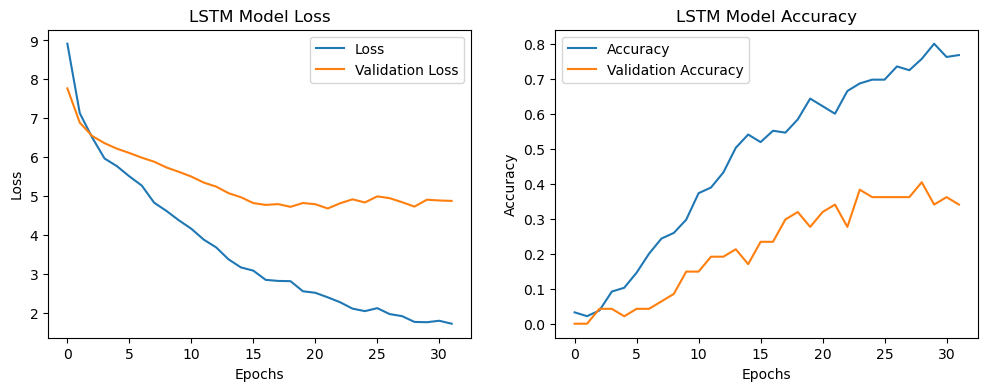

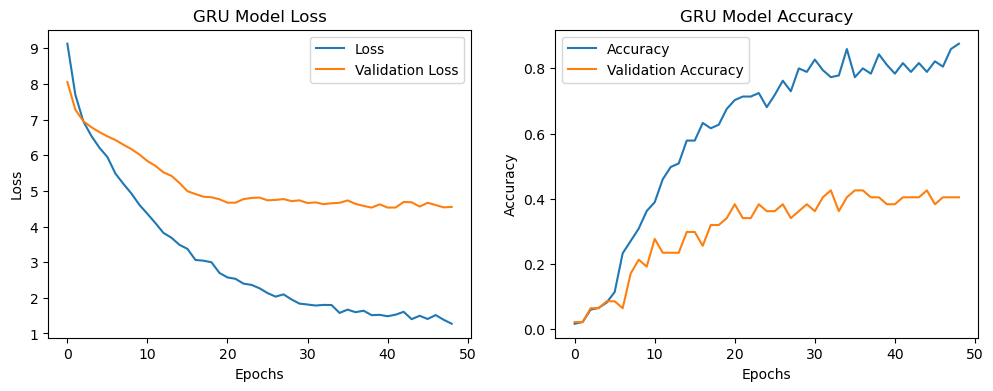

In [22]:
plot_history(history_lstm, 'LSTM')
plot_history(history_gru, 'GRU')

In [23]:
model_lstm = tf.keras.models.load_model('chatbot_model_LSTM.keras')

model_gru = tf.keras.models.load_model('chatbot_model_GRU.keras')


In [24]:
def preprocess_user_input(sentence):
    sentence = preprocess_text(sentence)
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=X_train.shape[1])
    return padded

In [25]:
def predict_class(sentence, model):
    padded = preprocess_user_input(sentence)
    res = model.predict(padded)[0]
    ERROR_THRESHOLD = 0.5  # Increased threshold for higher confidence
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

In [26]:
def get_response(ints, intents_json, context):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag'] == tag:
            if 'context_set' in i:
                context['set'] = i['context_set']
            if not 'context_filter' in i or (context.get('set') and 'context_filter' in i and i['context_filter'] == context['set']):
                result = random.choice(i['responses'])
                break
    return result

In [27]:
def enhanced_response(ints, intents_json, context):
    tag = ints[0]['intent']
    if tag in ['suicide', 'depressed', 'sad', 'worthless']:
        return random.choice([
            "I'm really sorry you're feeling this way. It's important to talk to someone who can provide support. Consider reaching out to a mental health professional.",
            "Your feelings are valid. Try to engage in activities that you enjoy and reach out to friends or family for support.",
            "It might help to focus on small, manageable tasks and take things one step at a time. You're not alone, and there are people who care about you.",
            "Please consider calling a mental health hotline or talking to a professional. They can offer the support you need."
        ])
    elif tag == 'name':
        return random.choice([
            "I'm a chatbot created to help you. How can I assist you today?",
            "I'm an AI-based chatbot here to support you. What would you like to talk about?",
            "I'm a virtual assistant here to help. What can I do for you today?"
        ])
    else:
        return get_response(ints, intents_json, context)

In [28]:
def chatbot_response(msg, context):
    ints = predict_class(msg, model_lstm)
    if ints:
        res = enhanced_response(ints, data, context)
    else:
        res = random.choice([
            "I'm here to help. Can you tell me more about how you're feeling?",
            "I understand this is difficult. Let's talk about what's on your mind.",
            "It's okay to feel this way. I'm here to listen. Can you share more with me?",
        ])
    return res

In [29]:
def analyze_model_limitations(y_true, y_pred):
    incorrect_predictions = y_true != y_pred
    num_incorrect = np.sum(incorrect_predictions)
    incorrect_percentage = (num_incorrect / len(y_true)) * 100
    print(f"Number of incorrect predictions: {num_incorrect}")
    print(f"Percentage of incorrect predictions: {incorrect_percentage:.2f}%")
    # Further analysis can include confusion matrix and error analysis
    return incorrect_predictions

In [30]:
def ethical_considerations():
    considerations = """
    Ethical Considerations in AI-based Chatbot Development:
    1. **Privacy**: Ensure user data is kept confidential and secure.
    2. **Bias**: Mitigate biases in training data to prevent discriminatory responses.
    3. **Transparency**: Inform users that they are interacting with an AI-based system.
    4. **Dependence**: Avoid creating dependency on the chatbot for emotional support, provide resources for professional help.
    5. **Accuracy**: Ensure the chatbot provides accurate information and avoids harm.
    """
    print(considerations)

In [31]:
def chat():
    print("Chatbot is running. Type 'quit' to stop.")
    context = {}
    ethical_considerations()
    while True:
        message = input("You: ")
        if message.lower() == "quit":
            break
        response = chatbot_response(message, context)
        print(f"Chatbot: {response}")

if __name__ == "__main__":
    chat()

Chatbot is running. Type 'quit' to stop.

    Ethical Considerations in AI-based Chatbot Development:
    1. **Privacy**: Ensure user data is kept confidential and secure.
    2. **Bias**: Mitigate biases in training data to prevent discriminatory responses.
    3. **Transparency**: Inform users that they are interacting with an AI-based system.
    4. **Dependence**: Avoid creating dependency on the chatbot for emotional support, provide resources for professional help.
    5. **Accuracy**: Ensure the chatbot provides accurate information and avoids harm.
    


KeyboardInterrupt: Interrupted by user

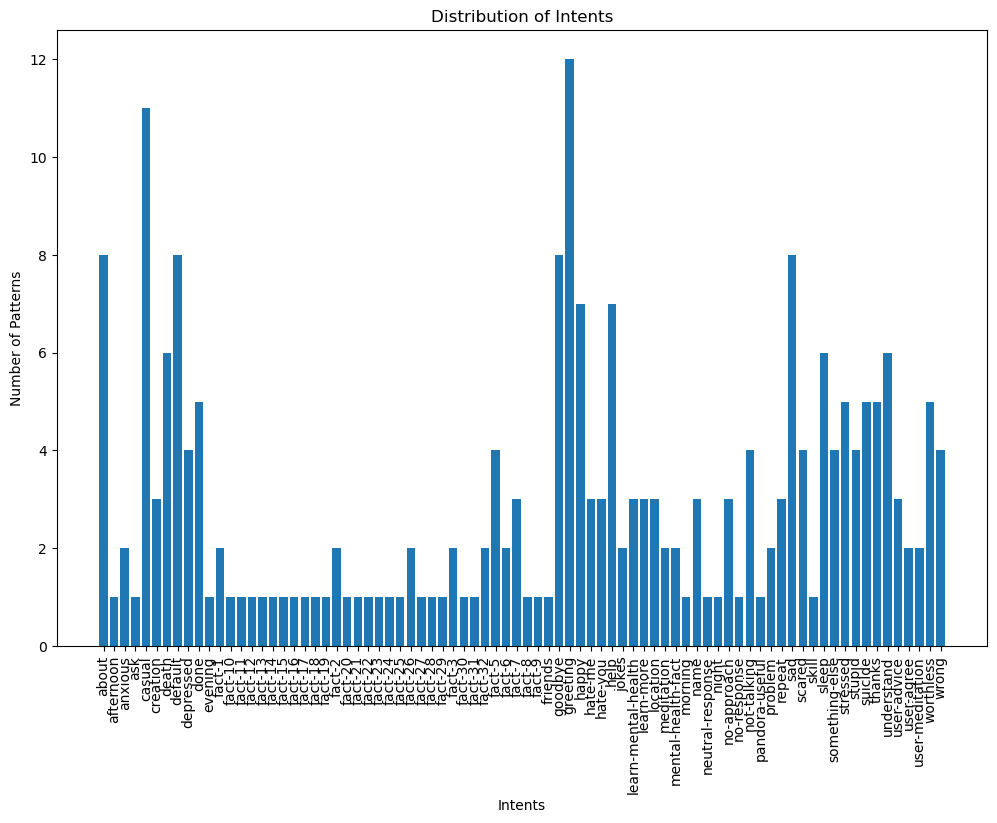

Class distribution before SMOTE: Counter({44: 12, 4: 11, 43: 8, 0: 8, 65: 8, 7: 8, 48: 7, 45: 7, 68: 6, 6: 6, 74: 6, 73: 5, 70: 5, 78: 5, 9: 5, 72: 5, 8: 4, 61: 4, 66: 4, 79: 4, 71: 4, 69: 4, 37: 4, 5: 3, 56: 3, 47: 3, 46: 3, 64: 3, 52: 3, 59: 3, 51: 3, 75: 3, 50: 3, 39: 3, 2: 2, 49: 2, 63: 2, 76: 2, 53: 2, 77: 2, 54: 2, 11: 2, 22: 2, 33: 2, 38: 2, 29: 2, 36: 2, 55: 1, 1: 1, 10: 1, 58: 1, 60: 1, 57: 1, 67: 1, 42: 1, 3: 1, 62: 1, 40: 1, 41: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 30: 1, 31: 1, 32: 1, 34: 1, 35: 1})
Epoch 1/150


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.0083 - loss: 9.5108 - val_accuracy: 0.0426 - val_loss: 7.7361
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0767 - loss: 7.2739 - val_accuracy: 0.0213 - val_loss: 6.8524
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0844 - loss: 6.3760 - val_accuracy: 0.0213 - val_loss: 6.5108
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0740 - loss: 6.0692 - val_accuracy: 0.0426 - val_loss: 6.3325
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1214 - loss: 5.7072 - val_accuracy: 0.0426 - val_loss: 6.1895
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1532 - loss: 5.3162 - val_accuracy: 0.0426 - val_loss: 6.0724
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1715 - loss: 5.0646 - val_accuracy: 0.0851 - val_loss: 5.9320
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2565 - loss: 4.7680 - val_accuracy: 0.1277 - val_loss: 5.

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.0029 - loss: 9.6867 - val_accuracy: 0.0426 - val_loss: 8.0478
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0390 - loss: 7.8920 - val_accuracy: 0.0213 - val_loss: 7.2692
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0355 - loss: 6.8122 - val_accuracy: 0.0426 - val_loss: 6.9491
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1091 - loss: 6.5286 - val_accuracy: 0.0426 - val_loss: 6.7797
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2093 - loss: 5.9967 - val_accuracy: 0.0638 - val_loss: 6.6444
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2072 - loss: 5.7327 - val_accuracy: 0.0851 - val_loss: 6.5065
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2465 - loss: 5.5537 - val_accuracy: 0.1277 - val_loss: 6.3940
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2275 - loss: 5.2504 - val_accuracy: 0.1489 - val_loss: 6.

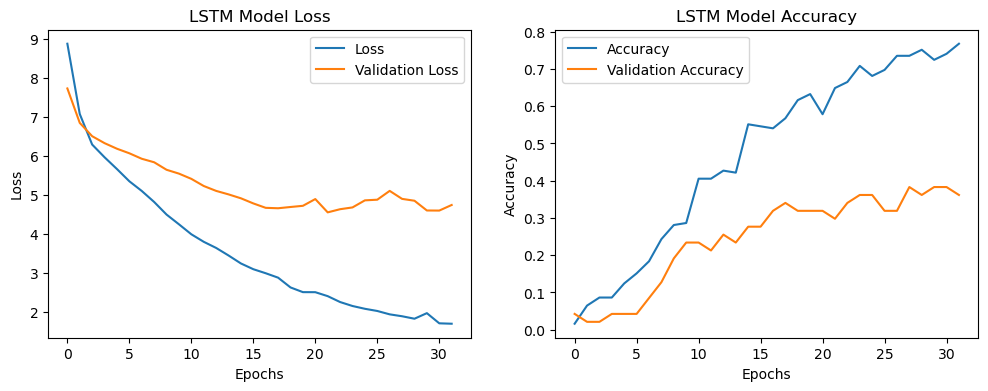

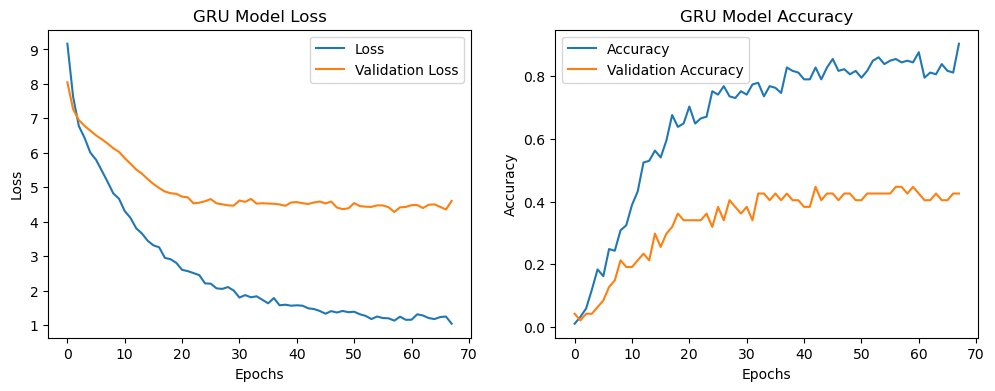

Chatbot is running. Type 'quit' to stop.

    Ethical Considerations in AI-based Chatbot Development:
    1. **Privacy**: Ensure user data is kept confidential and secure.
    2. **Bias**: Mitigate biases in training data to prevent discriminatory responses.
    3. **Transparency**: Inform users that they are interacting with an AI-based system.
    4. **Dependence**: Avoid creating dependency on the chatbot for emotional support, provide resources for professional help.
    5. **Accuracy**: Ensure the chatbot provides accurate information and avoids harm.
    


You:  good morning


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
Chatbot: Sorry, I didn't understand that.


You:  morning


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Chatbot: Sorry, I didn't understand that.


You:  what are you?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Chatbot: Let's discuss further why you're feeling this way.


KeyboardInterrupt: Interrupted by user

In [34]:
import json
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SpatialDropout1D, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import logging

# Load intents
with open('intents.json') as file:
    data = json.load(file)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w not in stop_words and w.isalnum()]
    return " ".join(tokens)

# Prepare data
words = []
classes = []
documents = []
for intent in data['intents']:
    for pattern in intent['patterns']:
        pattern = preprocess_text(pattern)
        words.extend(pattern.split())
        documents.append((pattern, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = sorted(set(words))
classes = sorted(set(classes))

# Intent distribution analysis
intent_counts = {intent: 0 for intent in classes}
for doc in documents:
    intent_counts[doc[1]] += 1

plt.figure(figsize=(12, 8))
plt.bar(intent_counts.keys(), intent_counts.values())
plt.title('Distribution of Intents')
plt.xlabel('Intents')
plt.ylabel('Number of Patterns')
plt.xticks(rotation=90)
plt.show()

# Prepare training data
training_sentences = [doc[0] for doc in documents]
training_labels = [classes.index(doc[1]) for doc in documents]
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(training_sentences)
X_train = tokenizer.texts_to_sequences(training_sentences)
X_train = pad_sequences(X_train)

y_train = np.array(training_labels)
class_counts = Counter(y_train)
print("Class distribution before SMOTE:", class_counts)
apply_smote = all(count >= 6 for count in class_counts.values())

if apply_smote:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE()
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
else:
    X_train_res, y_train_res = X_train, y_train

X_train, X_val, y_train, y_val = train_test_split(X_train_res, y_train_res, test_size=0.2, random_state=42)

# Build the model
def build_model(model_type='LSTM'):
    model = Sequential()
    model.add(Embedding(input_dim=2000, output_dim=128, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.3))
    if model_type == 'LSTM':
        model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01))))
    elif model_type == 'GRU':
        model.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01))))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(classes), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train and evaluate the model
def train_and_evaluate(model_type='LSTM'):
    model = build_model(model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=150, batch_size=5, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])
    model.save(f'chatbot_model_{model_type}.keras')
    val_predictions = model.predict(X_val)
    val_predictions = np.argmax(val_predictions, axis=1)
    unique_y_val = np.unique(y_val)
    unique_classes = [classes[i] for i in unique_y_val]
    print(f"Model: {model_type}")
    print(classification_report(y_val, val_predictions, labels=unique_y_val, target_names=unique_classes, zero_division=1))
    return history

history_lstm = train_and_evaluate('LSTM')
history_gru = train_and_evaluate('GRU')

# Plot model history
def plot_history(history, model_type):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type} Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history_lstm, 'LSTM')
plot_history(history_gru, 'GRU')

# Load the trained LSTM model
model_lstm = tf.keras.models.load_model('chatbot_model_LSTM.keras')

# Load the trained GRU model
model_gru = tf.keras.models.load_model('chatbot_model_GRU.keras')

# Preprocess user input
def preprocess_user_input(sentence):
    sentence = preprocess_text(sentence)
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=X_train.shape[1])
    return padded

# Predict class
def predict_class(sentence, model):
    padded = preprocess_user_input(sentence)
    res = model.predict(padded)[0]
    ERROR_THRESHOLD = 0.5  # Increased threshold for higher confidence
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

# Get response based on intent
def get_response(ints, intents_json, context):
    if not ints:
        return "Sorry, I didn't understand that."
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag'] == tag:
            if 'context_set' in i:
                context['set'] = i['context_set']
            if not 'context_filter' in i or (context.get('set') and 'context_filter' in i and i['context_filter'] == context['set']):
                result = random.choice(i['responses'])
                return result
    return "Sorry, I didn't understand that."

# Chatbot response function
def chatbot_response(msg, context):
    ints = predict_class(msg, model_lstm)
    res = get_response(ints, data, context)
    return res

# Ethical considerations
def ethical_considerations():
    considerations = """
    Ethical Considerations in AI-based Chatbot Development:
    1. **Privacy**: Ensure user data is kept confidential and secure.
    2. **Bias**: Mitigate biases in training data to prevent discriminatory responses.
    3. **Transparency**: Inform users that they are interacting with an AI-based system.
    4. **Dependence**: Avoid creating dependency on the chatbot for emotional support, provide resources for professional help.
    5. **Accuracy**: Ensure the chatbot provides accurate information and avoids harm.
    """
    print(considerations)

# Chat function
def chat():
    print("Chatbot is running. Type 'quit' to stop.")
    context = {}
    ethical_considerations()
    while True:
        message = input("You: ")
        if message.lower() == "quit":
            break
        response = chatbot_response(message, context)
        print(f"Chatbot: {response}")

if __name__ == "__main__":
    chat()


In [40]:
import json
import numpy as np
import random
import nltk
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from ipywidgets import widgets, VBox, HBox
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Load intents
with open('intents.json') as file:
    data = json.load(file)

# Load models
model_lstm = tf.keras.models.load_model('chatbot_model_LSTM.keras')
model_gru = tf.keras.models.load_model('chatbot_model_GRU.keras')

# Initialize variables
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
tokenizer = Tokenizer(num_words=2000)
context = {}
previous_responses = {}

# Prepare the classes variable
classes = sorted(set(intent['tag'] for intent in data['intents']))

# Preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w not in stop_words and w.isalnum()]
    return " ".join(tokens)

# Prepare the tokenizer on the entire dataset
def prepare_tokenizer(data):
    sentences = []
    for intent in data['intents']:
        for pattern in intent['patterns']:
            sentences.append(preprocess_text(pattern))
    tokenizer.fit_on_texts(sentences)

prepare_tokenizer(data)

# Preprocess user input
def preprocess_user_input(sentence):
    sentence = preprocess_text(sentence)
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=200)
    return padded

# Predict class with enhanced visualization
def predict_class(sentence, model):
    padded = preprocess_user_input(sentence)
    res = model.predict(padded)[0]
    ERROR_THRESHOLD = 0.5
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    
    # Enhanced visualization
    visualize_prediction(res)
    
    return return_list

# Enhanced Visualization function
def visualize_prediction(probabilities):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=classes, y=probabilities, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Intents', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title('Model Prediction Confidence', fontsize=14)
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# Get response based on prediction
def get_response(ints, intents_json, context, previous_responses):
    if not ints:
        return "I'm sorry, I don't have an appropriate response for that."

    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    
    for intent in list_of_intents:
        if intent['tag'] == tag:
            if 'context_set' in intent:
                context['set'] = intent['context_set']
            if not 'context_filter' in intent or (context.get('set') and 'context_filter' in intent and intent['context_filter'] == context['set']):
                responses = intent['responses']
                if tag in previous_responses:
                    response = random.choice([r for r in responses if r != previous_responses[tag]])
                else:
                    response = random.choice(responses)
                previous_responses[tag] = response
                return response
    return "I couldn't find an appropriate response in my intents."

# Chatbot response function
def chatbot_response(msg, context, model, previous_responses):
    ints = predict_class(msg, model)
    res = get_response(ints, data, context, previous_responses)
    return res


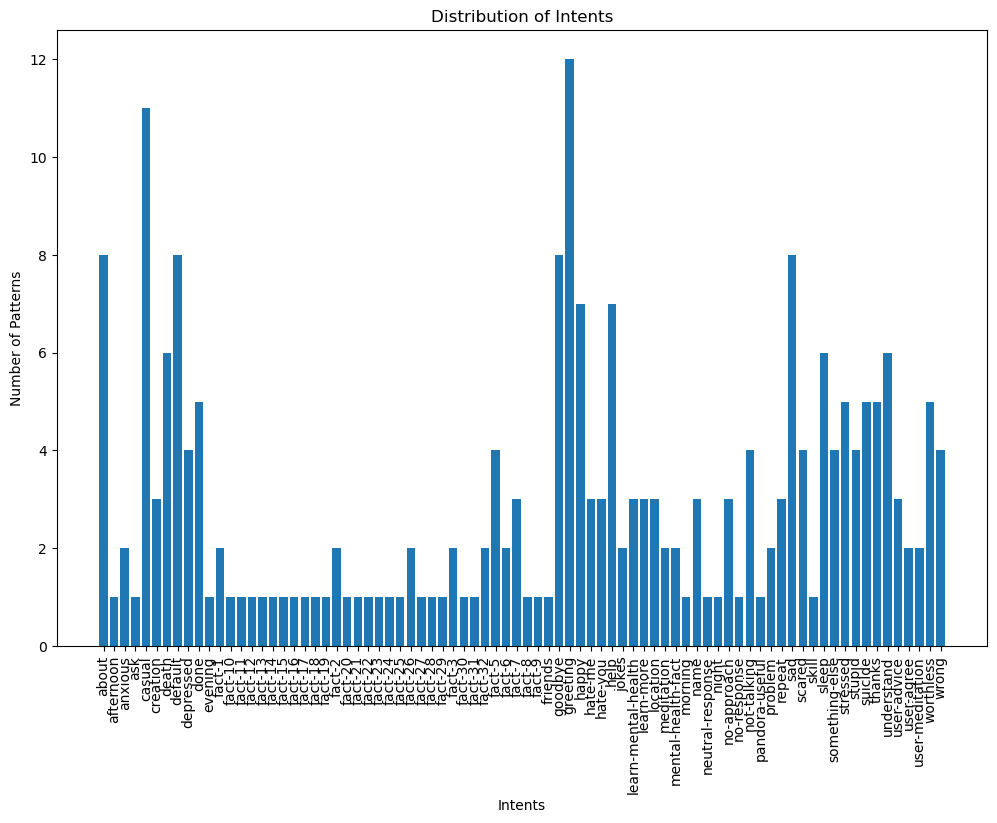

Class distribution before SMOTE: Counter({44: 12, 4: 11, 43: 8, 0: 8, 65: 8, 7: 8, 48: 7, 45: 7, 68: 6, 6: 6, 74: 6, 73: 5, 70: 5, 78: 5, 9: 5, 72: 5, 8: 4, 61: 4, 66: 4, 79: 4, 71: 4, 69: 4, 37: 4, 5: 3, 56: 3, 47: 3, 46: 3, 64: 3, 52: 3, 59: 3, 51: 3, 75: 3, 50: 3, 39: 3, 2: 2, 49: 2, 63: 2, 76: 2, 53: 2, 77: 2, 54: 2, 11: 2, 22: 2, 33: 2, 38: 2, 29: 2, 36: 2, 55: 1, 1: 1, 10: 1, 58: 1, 60: 1, 57: 1, 67: 1, 42: 1, 3: 1, 62: 1, 40: 1, 41: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 30: 1, 31: 1, 32: 1, 34: 1, 35: 1})
Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.0045 - loss: 9.4931 - val_accuracy: 0.0426 - val_loss: 7.7551
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0203 - loss: 7.4999 - val_accuracy: 0.0426 - val_loss: 6.8716
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0533 - loss: 6.5044 - val_accuracy: 0.0213 - val_loss: 6.5291
Epoch 4/150
37/37 ━━━━━

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.0164 - loss: 9.7616 - val_accuracy: 0.0000e+00 - val_loss: 8.0455
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0243 - loss: 7.8069 - val_accuracy: 0.0000e+00 - val_loss: 7.2708
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0450 - loss: 7.0207 - val_accuracy: 0.0000e+00 - val_loss: 6.9429
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0771 - loss: 6.5228 - val_accuracy: 0.0426 - val_loss: 6.7663
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1369 - loss: 6.2345 - val_accuracy: 0.0426 - val_loss: 6.6275
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1043 - loss: 5.9925 - val_accuracy: 0.1064 - val_loss: 6.5056
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3195 - loss: 5.3935 - val_accuracy: 0.0851 - val_loss: 6.4012
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2037 - loss: 5.3506 - val_accuracy: 0.1277 - 

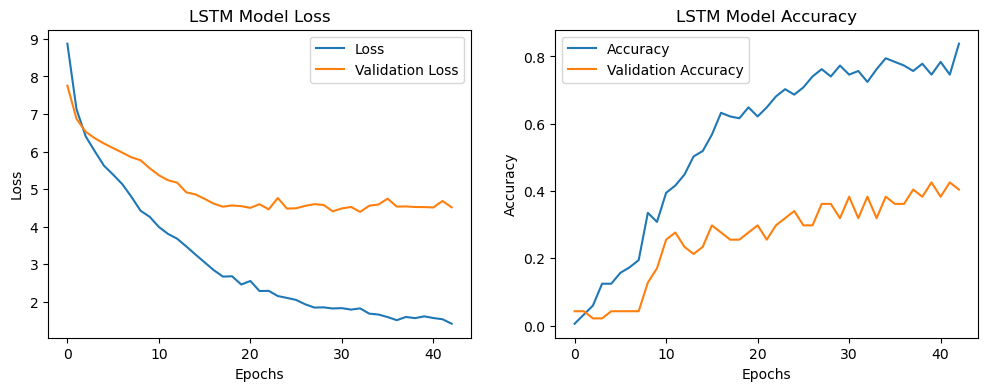

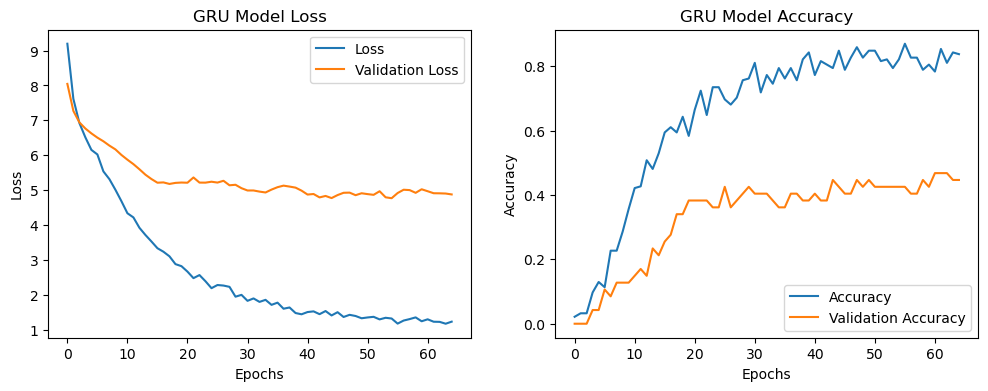

In [14]:
import json
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SpatialDropout1D, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from ipywidgets import widgets, VBox, HBox
from IPython.display import display

# Load intents
with open('intents.json') as file:
    data = json.load(file)

# Initialize variables
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
tokenizer = Tokenizer(num_words=2000)
context = {}
previous_responses = {}

# Prepare the classes variable
classes = sorted(set(intent['tag'] for intent in data['intents']))

# Preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w not in stop_words and w.isalnum()]
    return " ".join(tokens)

# Prepare the words, classes, and documents
words = []
documents = []
for intent in data['intents']:
    for pattern in intent['patterns']:
        pattern = preprocess_text(pattern)
        words.extend(pattern.split())
        documents.append((pattern, intent['tag']))

words = sorted(set(words))

# Visualize the distribution of intents
intent_counts = {intent: 0 for intent in classes}
for doc in documents:
    intent_counts[doc[1]] += 1

plt.figure(figsize=(12, 8))
plt.bar(intent_counts.keys(), intent_counts.values())
plt.title('Distribution of Intents')
plt.xlabel('Intents')
plt.ylabel('Number of Patterns')
plt.xticks(rotation=90)
plt.show()

# Prepare training data
training_sentences = [doc[0] for doc in documents]
training_labels = [classes.index(doc[1]) for doc in documents]

# Tokenize and pad sequences
tokenizer.fit_on_texts(training_sentences)
X_train = tokenizer.texts_to_sequences(training_sentences)
X_train = pad_sequences(X_train)

y_train = np.array(training_labels)

# Handle class imbalance
class_counts = Counter(y_train)
print("Class distribution before SMOTE:", class_counts)
apply_smote = all(count >= 6 for count in class_counts.values())

if apply_smote:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE()
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
else:
    X_train_res, y_train_res = X_train, y_train

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_res, y_train_res, test_size=0.2, random_state=42)

# Build the model
def build_model(model_type='LSTM'):
    model = Sequential()
    model.add(Embedding(input_dim=2000, output_dim=128, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.3))
    if model_type == 'LSTM':
        model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01))))
    elif model_type == 'GRU':
        model.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01))))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(classes), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train and evaluate the model
def train_and_evaluate(model_type='LSTM'):
    model = build_model(model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=150, batch_size=5, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])
    model.save(f'chatbot_model_{model_type}.keras')
    val_predictions = model.predict(X_val)
    val_predictions = np.argmax(val_predictions, axis=1)
    unique_y_val = np.unique(y_val)
    unique_classes = [classes[i] for i in unique_y_val]
    print(f"Model: {model_type}")
    print(classification_report(y_val, val_predictions, labels=unique_y_val, target_names=unique_classes, zero_division=1))
    return history

# Train LSTM and GRU models
history_lstm = train_and_evaluate('LSTM')
history_gru = train_and_evaluate('GRU')

# Plot training history
def plot_history(history, model_type):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type} Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history_lstm, 'LSTM')
plot_history(history_gru, 'GRU')

# Load trained models
model_lstm = tf.keras.models.load_model('chatbot_model_LSTM.keras')
model_gru = tf.keras.models.load_model('chatbot_model_GRU.keras')

# Preprocess user input
def preprocess_user_input(sentence):
    sentence = preprocess_text(sentence)
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=X_train.shape[1])
    return padded

# Predict class of user input with visualization option
def predict_class(sentence, model, visualize=False):
    padded = preprocess_user_input(sentence)
    res = model.predict(padded)[0]
    ERROR_THRESHOLD = 0.5  # Increased threshold for higher confidence
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})

    if visualize:
        visualize_prediction(res)
        
    return return_list

# Visualization function
def visualize_prediction(probabilities):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(probabilities)), probabilities)
    plt.xticks(range(len(probabilities)), classes, rotation=90)
    plt.xlabel('Intents')
    plt.ylabel('Probability')
    plt.title('Model Prediction Confidence')
    plt.show()

# Get response based on prediction
def get_response(ints, intents_json, context, previous_responses):
    if not ints:
        return "I'm sorry, I don't have an appropriate response for that."

    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    
    for intent in list_of_intents:
        if intent['tag'] == tag:
            if 'context_set' in intent:
                context['set'] = intent['context_set']
            if not 'context_filter' in intent or (context.get('set') and 'context_filter' in intent and intent['context_filter'] == context['set']):
                responses = intent['responses']
                if tag in previous_responses:
                    response = random.choice([r for r in responses if r != previous_responses[tag]])
                else:
                    response = random.choice(responses)
                previous_responses[tag] = response
                return response
    return "I couldn't find an appropriate response in my intents."

# Chatbot response function
def chatbot_response(msg, context, model, previous_responses, visualize=False):
    ints = predict_class(msg, model, visualize=visualize)
    res = get_response(ints, data, context, previous_responses)
    return res

# Widgets for the chat interface
chat_output = widgets.Output()
chat_input = widgets.Text(placeholder='Type your message here...')
send_button = widgets.Button(description='Send')
model_selector = widgets.Dropdown(
    options=['LSTM', 'GRU'],
    value='LSTM',
    description='Model:'
)

def send_message(_):
    with chat_output:
        user_message = chat_input.value
        chat_input.value = ''
        print(f'You: {user_message}')
        selected_model = model_lstm if model_selector.value == 'LSTM' else model_gru
        visualize = False  # Directly set visualization to False
        response = chatbot_response(user_message, context, selected_model, previous_responses, visualize=visualize)
        print(f'Chatbot: {response}')
        chat_output.append_stdout("\n")

send_button.on_click(send_message)

# Display the interface
display(VBox([model_selector, chat_output, HBox([chat_input, send_button])]))

